## Inverse Compositional Algorithm

This is the notebook to explain to Edwin how to use the IC.

Let's begin by installing the prerequisite modules:

In [ ]:
!pip install hydra-core omegaconf pillow scikit-learn scipy opencv-python numpy einops pandas networkx scikit-image ipython matplotlib seaborn

In [1]:
# you don't really care about this code
# these are just basic module imports

import sys
import os
from pathlib import Path
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

Let's instanciate the Inverse Compositional class:

In [2]:
from src.registration.multiscale_registration import MultiscaleIC

# Create the single scale IC component first
from src.registration.single_scale import InverseCompositional
from src.registration.gradients import Gradients


# Create gradient method
# you can leave it like this
gradient_method = Gradients(
    method='farid5',
    C=1,
    device=device
)

# Create single scale IC
single_scale_ic = InverseCompositional(
    transform_type='homography',        # 'translation', 'euclidean', 'similarity', 'affinity' or 'homography'
    gradient_method=gradient_method,
    error_function='l2',                # 'l2', 'lorentzian', 'geman_mcclure', 'charbonnier'. The first paper uses l2. Lorentzian is better
    delta=5,                            # you can leave it like this
    epsilon=1e-3,                       # convergence threshold
    max_iter=120,                       # max number of iterations
    lambda_init=80.0,                   # not used if you use l2 error_function
    lambda_min=5.0,                     # same
    lambda_decay=0.9                    # same
)



We load the images:

In [3]:
import numpy as np
import torch
from PIL import Image


I1 = np.array(Image.open('data/extracted/communities/9/204.jpg'))
I2 = np.array(Image.open('data/extracted/communities/9/11876.jpg'))

# (C, H, W format)
to_torch = lambda I: torch.tensor(I, dtype=torch.float32).unsqueeze(0).to(device) / 255
I1_torch = to_torch(I1)
I2_torch = to_torch(I2)


Now, let's apply the single scale inverse compositional algorithm!

In [4]:
T = single_scale_ic.run(I1=I1_torch, I2=I2_torch)
warped = T.warp(I2_torch.unsqueeze(0)) # warp function signature: (B, C, H, W)
mask = T.visibility_mask(128, 128, delta=0)
warped[0,0][~mask] = 1

We show the results in this cell:

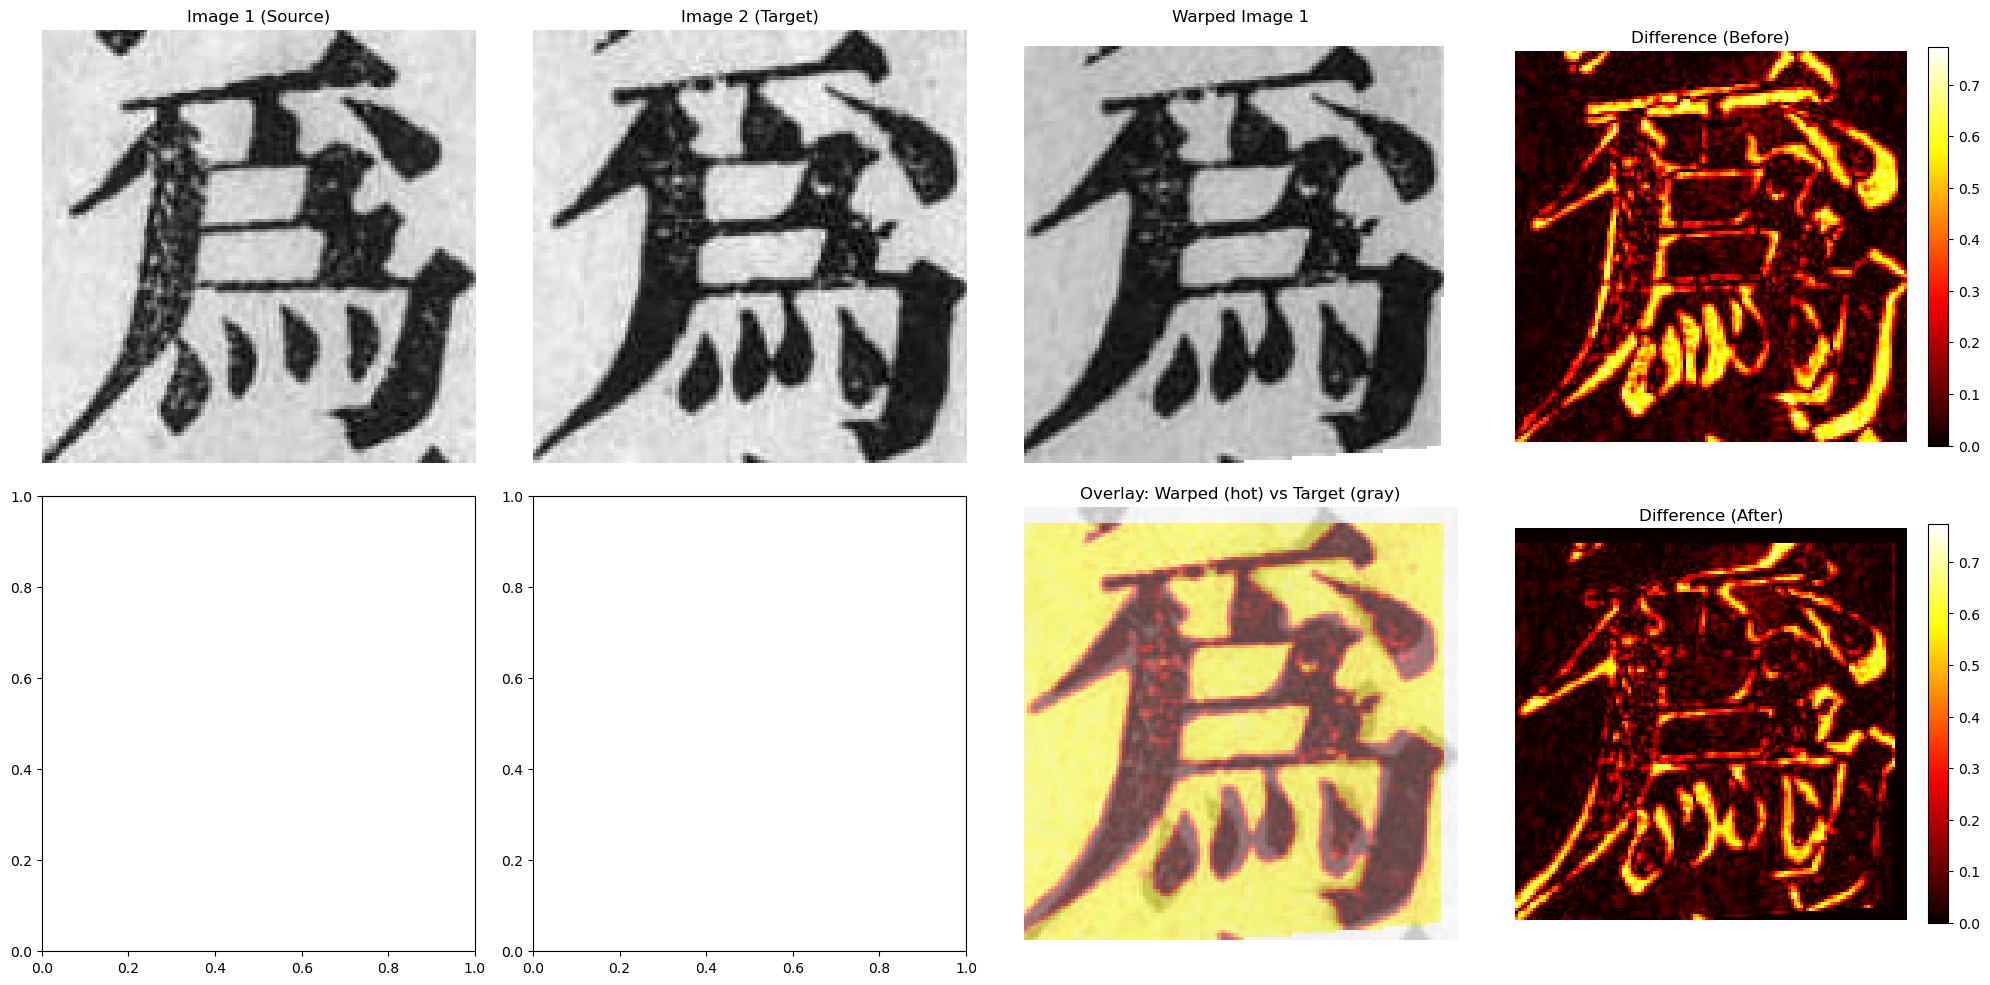


=== Registration Statistics ===
Mean absolute difference (before): 0.1443
Mean absolute difference (after): 0.1053
Improvement: 27.0%


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.ndimage import map_coordinates

def plot_registration(im1, im2, warped):
    """
    Visualize the registration by showing displacement field and warped image.
    """
    h, w = im1.shape
    
    
    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Original images
    axes[0, 0].imshow(im1, cmap='gray')
    axes[0, 0].set_title('Image 1 (Source)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(im2, cmap='gray')
    axes[0, 1].set_title('Image 2 (Target)')
    axes[0, 1].axis('off')
    
    # Warped image
    axes[0, 2].imshow(warped, cmap='gray')
    axes[0, 2].set_title('Warped Image 1')
    axes[0, 2].axis('off')
    
    # Difference before warping
    diff_before = np.abs(im1 - im2)
    diff_after = np.abs(warped - im1)

    vmin = min(diff_before.min(), diff_after.min())
    vmax = min(diff_before.max(), diff_after.max())

    diff_after[~mask] = 0

    im_diff_before = axes[0, 3].imshow(diff_before, cmap='hot', vmin=vmin, vmax=vmax)
    axes[0, 3].set_title('Difference (Before)')
    axes[0, 3].axis('off')
    plt.colorbar(im_diff_before, ax=axes[0, 3], fraction=0.046)
    
    
    
    # Overlay: warped vs target
    axes[1, 2].imshow(im1, cmap='gray', alpha=0.5)
    axes[1, 2].imshow(warped, cmap='hot', alpha=0.5)
    axes[1, 2].set_title('Overlay: Warped (hot) vs Target (gray)')
    axes[1, 2].axis('off')
    
    # Difference after warping
    
    im_diff_after = axes[1, 3].imshow(diff_after, cmap='hot', vmin=vmin, vmax=vmax)
    axes[1, 3].set_title('Difference (After)')
    axes[1, 3].axis('off')
    plt.colorbar(im_diff_after, ax=axes[1, 3], fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\n=== Registration Statistics ===")
    print(f"Mean absolute difference (before): {diff_before.mean():.4f}")
    print(f"Mean absolute difference (after): {diff_after.mean():.4f}")
    print(f"Improvement: {(1 - diff_after.mean()/diff_before.mean())*100:.1f}%")


plot_registration(I1_torch.squeeze(0).cpu(), I2_torch.squeeze(0).cpu(), warped.cpu().squeeze(0).squeeze(0))

## Improved Algorithm

In [16]:
# Create Gaussian pyramid
from src.registration.gaussian_pyramid import GaussianPyramid
gaussian_pyramid = GaussianPyramid(
    eta=0.5,                        # unzooming factor
    sigma_0=0.6,                    # initial std of the gaussian kernel
    ksize_factor=8,                 # kernel size = 2 * sigma * ksize_factor | 1
    min_size=32                     # size of the coarsest image in the pyramid
)

# Create the multiscale registration
multiscale_registration = MultiscaleIC(
    singleScaleIC=single_scale_ic,
    gaussianPyramid=gaussian_pyramid
)

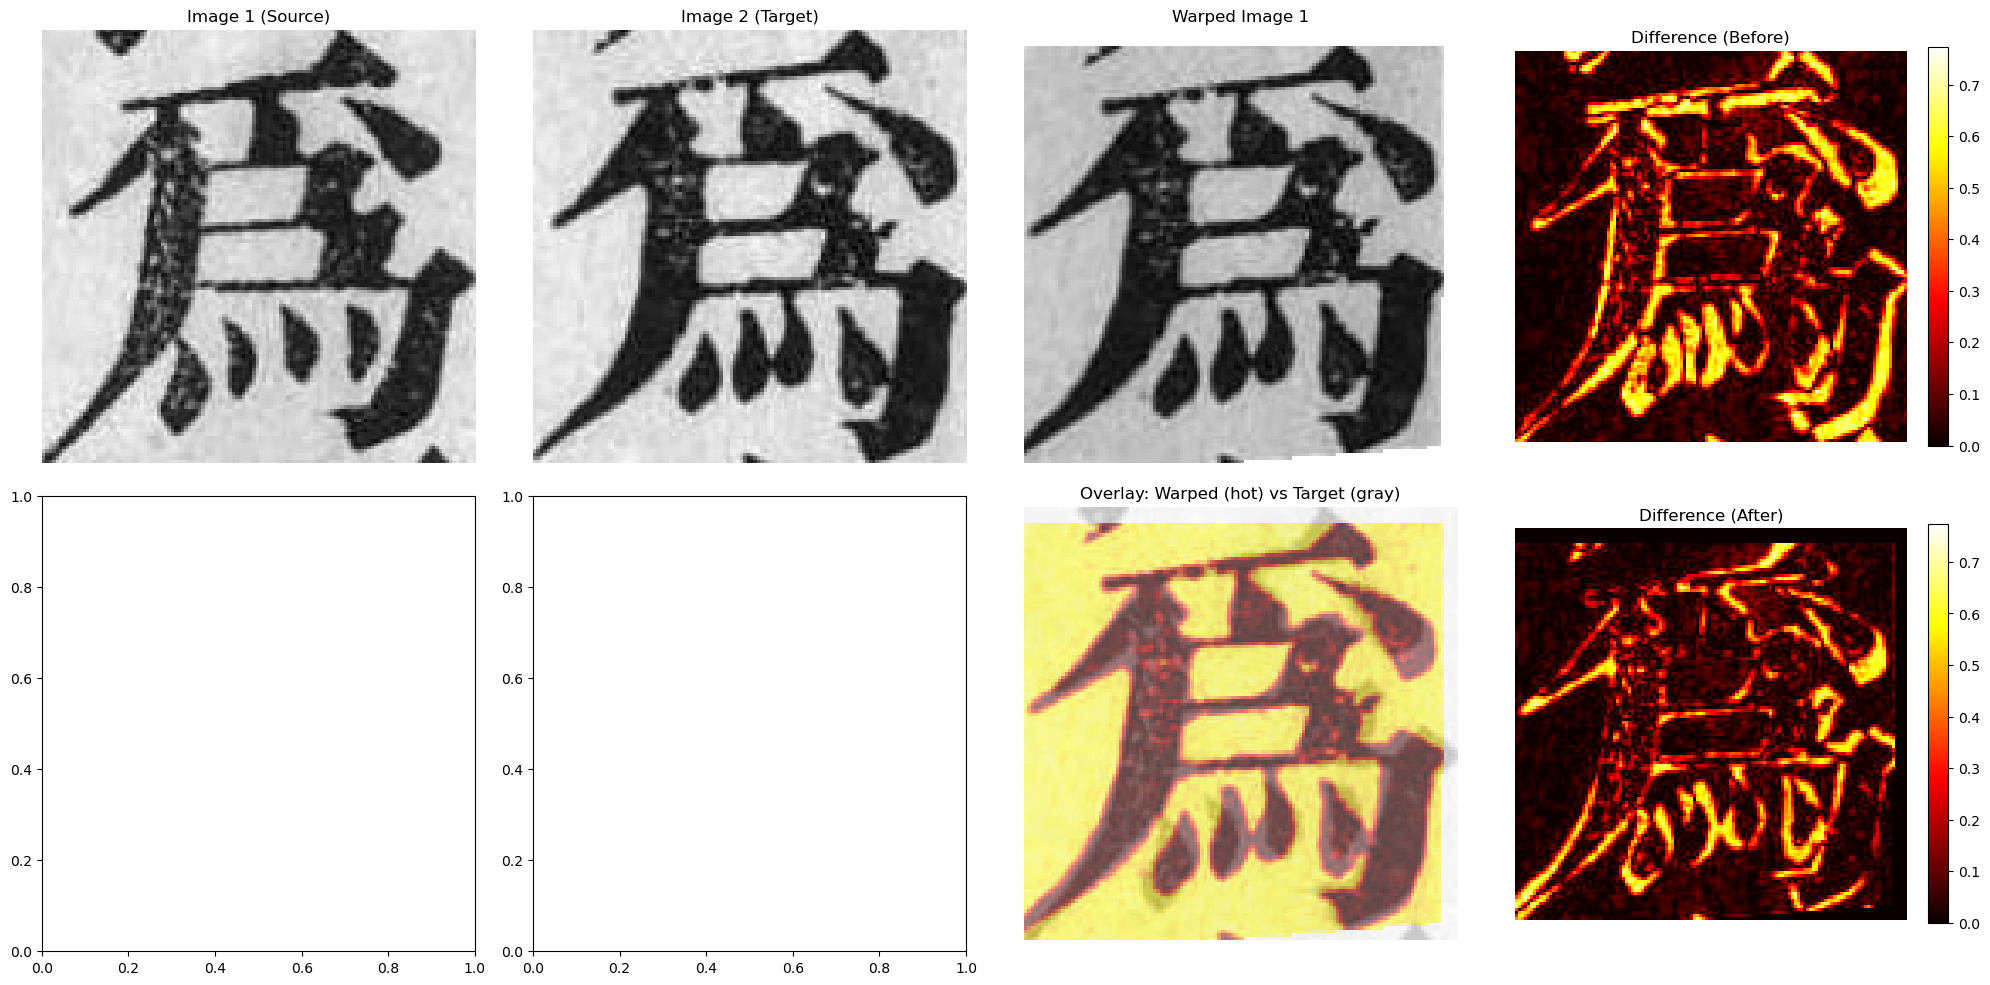


=== Registration Statistics ===
Mean absolute difference (before): 0.1443
Mean absolute difference (after): 0.1053
Improvement: 27.0%


In [17]:
T = multiscale_registration.run(I1=I1_torch, I2=I2_torch)
warped = T.warp(I2_torch.unsqueeze(0)) # warp function signature: (B, C, H, W)
mask = T.visibility_mask(128, 128, delta=0)
warped[0,0][~mask] = 1

plot_registration(I1_torch.squeeze(0).cpu(), I2_torch.squeeze(0).cpu(), warped.cpu().squeeze(0).squeeze(0))